## Preprocessament dels conjunts de dades

In [1]:
! pip install ydata-profiling

You should consider upgrading via the 'C:\Users\jesus\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [2]:
! pip install gitpython


You should consider upgrading via the 'C:\Users\jesus\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [3]:
from ydata_profiling import ProfileReport
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import git
import os
from pandas_profiling import ProfileReport

c:\Users\jesus\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


C:\Users\jesus\AppData\Local\Temp\ipykernel_4204\2079636952.py:8: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


Tranformar Dataset (Eliminació i canvi del ordre de les columnes, canvi del noms dels atributs, canvi del tipus de dades)

In [12]:
def check_and_transform_csv(file_path,  column_mapping):
    
    expected_columns = ["Date", "Open", "High", "Low", "Close", "Volume"]

    # Carregar el CSV correctament
    df = pd.read_csv(file_path)
    
    # Comprovar si ja té el format correcte
    if list(df.columns) == expected_columns:
        print("El CSV ja té el format correcte. No s'han fet canvis.")
        return df
    
    # Verificar que totes les columnes de mapping existeixen al CSV
    if not set(column_mapping.keys()).issubset(set(df.columns)):
        raise ValueError("Algunes columnes del mapping no existeixen en el CSV proporcionat. Revisa les dades d'entrada.")
    
    # Renombrar les columnes segons el mapping proporcionat
    df.rename(columns=column_mapping, inplace=True)
    
    # Reordenar les columnes segons el format esperat
    df = df[expected_columns]

    print(f"CSV transformat")
    
    return df

column_mapping = {"Date": "Date", "Open": "Open", "High": "High", "Low": "Low", "Price": "Close", "Vol.": "Volume"}
#column_mapping = {"Fecha": "Date", "Apertura": "Open", "Máximo": "High", "Mínimo": "Low", "Price": "Último", "Vol.": "Volume"}

df = check_and_transform_csv("Conjunt de dades/stock_price_S&P500.csv", column_mapping)


CSV transformat


In [13]:
#Nomès dataset S&P500
#Omplir els Volume amb 0.0
def omplir_volume_buits(df):
    if 'Volume' in df.columns:
        df['Volume'] = df['Volume'].fillna('0.0')

    return df
df = omplir_volume_buits(df)

In [14]:
df

,Date,Open,High,Low,Close,Volume
0,01/31/2025,"6,096.79","6,120.91","6,030.93","6,040.53",0.0
1,01/30/2025,"6,050.75","6,086.64","6,027.46","6,071.17",0.0
2,01/29/2025,"6,057.70","6,062.83","6,012.96","6,039.31",0.0
3,01/28/2025,"6,026.97","6,074.54","5,994.63","6,067.70",0.0
4,01/27/2025,"5,969.04","6,017.17","5,962.92","6,012.28",0.0
...,...,...,...,...,...,...
1273,01/08/2020,"3,238.60","3,267.10","3,236.70","3,253.10",0.0
1274,01/07/2020,"3,241.90","3,244.90","3,232.40","3,237.20",0.0
1275,01/06/2020,"3,217.60","3,246.80","3,214.60","3,246.30",0.0
1276,01/03/2020,"3,226.40","3,246.20","3,222.30","3,234.80",0.0


In [15]:
def transform_dtypes(df):
    # Comprovar si la columna 'Date' ja és de tipus datetime
    if not pd.api.types.is_datetime64_any_dtype(df['Date']):
        # Convertir la columna "Date" a datetime amb el format correcte (dia.mes.any)
        df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y', errors='coerce')
        #df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y', errors='coerce')
    # Classificar les dates en ordre ascendent
    df = df.sort_values(by='Date', ascending=True).reset_index(drop=True)

    # Comprovar si les columnes 'Open', 'Close', 'Low', 'High' són numèriques
    # Comprovar si les columnes 'Open', 'Close', 'Low', 'High' són numèriques
    for col in ['Open', 'Close', 'Low', 'High']:
        if not pd.api.types.is_numeric_dtype(df[col]):
            # Substituir . dels milers i , dels decimals
            # Eliminar els punts (separadors de milers)
            #
            # df[col] = df[col].str.replace('.', ',', regex=False)
             # Substituir la coma decimal per un punt
            df[col] = df[col].str.replace(',', '', regex=False)
            # Convertir a float
            df[col] = pd.to_numeric(df[col], errors='coerce')


    # Comprovar si la columna 'Volume' és numèrica
    if not pd.api.types.is_numeric_dtype(df['Volume']):
        
        df['Volume'] = df['Volume'].replace({',': '.'}, regex=True)
        #df['Volume'] = df['Volume'].str.replace('K', '').astype(float) * 1_000  # Convertir a milions
        #df['Volume'] = df['Volume'].str.replace('M', '').astype(float) * 1_000_000
        
        def netejar_volume(valor):
            if isinstance(valor, str):
                valor = valor.replace(',', '.').strip().upper()
                try:
                    if valor.endswith('K'):
                        return float(valor[:-1]) * 1_000
                    elif valor.endswith('M'):
                        return float(valor[:-1]) * 1_000_000
                    elif valor.endswith('B'):
                        return float(valor[:-1]) * 1_000_000_000
                    else:
                        return float(valor)
                except ValueError:
                    return None
            elif isinstance(valor, (int, float)):
                return valor  
            else:
                return None  

        # Aplica la funció a la columna Volume
        df['Volume'] = df['Volume'].apply(netejar_volume)


        return df

df = transform_dtypes(df)
print(df.head())


        Date    Open    High     Low   Close  Volume
0 2020-01-02  3244.7  3258.1  3235.5  3257.8     0.0
1 2020-01-03  3226.4  3246.2  3222.3  3234.8     0.0
2 2020-01-06  3217.6  3246.8  3214.6  3246.3     0.0
3 2020-01-07  3241.9  3244.9  3232.4  3237.2     0.0
4 2020-01-08  3238.6  3267.1  3236.7  3253.1     0.0


Crear informe complet del Dataset

In [16]:
def Report(df):
    report_path = "Conjunt de dades Preprocessades/Report dels conjunts de dades/S&P500_Report.html"
    profile = ProfileReport(df, title="Pandas Profiling Report")
    profile.to_file(report_path)

    # Assumeixes que ja tens el repositori clonado
    repo = git.Repo(os.getcwd())
    repo.git.add(report_path)
    repo.index.commit("Afegit S&P500_Report.html automàticament")
    origin = repo.remote(name='origin')
    origin.push()

Report(df)

Export report to file: 100%|██████████| 1/1 [00:00<?, ?it/s]


In [17]:
#Per el dataset Hang_Seng
#Omplir els valors buits (NaN) de la columna Volume amb el valor següent més proper. 
#def omplir_volume_buits(df):
    #if 'Volume' in df.columns:
        #df['Volume'] = df['Volume'].fillna('0.0')

    #return df
#df = omplir_volume_buits(df)

Crear gràfiques per veure l'evolució dels preus en un període de temps. 

In [18]:
def graph(df):
    # Crear una còpia del dataframe amb "Date" com a índex, però sense eliminar la columna original
    trainCSV_indexed = df.set_index('Date', drop=False)

    # Representar gràficament les columnes Open, Close, Low i High amb la data com a eix X
    trainCSV_indexed[['Open', 'Close', 'Low', 'High']].plot(figsize=(12, 6), grid=True)

    # Afegir títol i etiquetes als eixos
    plt.title('Evolució dels preus de les accions')
    plt.xlabel('Data')
    plt.ylabel('Preu')
    plt.legend(title="Variables financeres")  # Afegir llegenda

    # Mostrar el gràfic
    plt.show()

    # Desar el gràfic com a imatge
    plt.savefig('Conjunt de dades Preprocessades/Gràfiques Preus Històrics/S&P500_grafic_accions.png')

    # Representar gràficament la data versus el preu de tancament (Close) en vermell
    df.plot('Date', 'Close', color="red")

    # Extreure només les 60 primeres files per fer el gràfic més clar
    new_data = df.head(60)

    # Representar gràficament la data versus el preu de tancament (Close) amb les 60 primeres files en verd
    new_data.plot('Date', 'Close', color="green")

    # Mostrar el gràfic
    plt.show()

graph(df)

C:\Users\jesus\AppData\Local\Temp\ipykernel_4204\3568004230.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
C:\Users\jesus\AppData\Local\Temp\ipykernel_4204\3568004230.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


Identificar outliers

In [19]:
# Identificar les columnes numèriques
numeric_columns = df.select_dtypes(include=['float64']).columns

# Detectar i mostrar valors atípics per columna
for column in numeric_columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

    print(f"\nColumna: {column}")
    print(f"Nombre de valors atípics: {len(outliers)}")
    print(outliers[[column]])  # Només imprimeix la columna amb els valors atípics



Columna: Open
Nombre de valors atípics: 66
         Open
49    2570.00
50    2508.60
51    2425.70
52    2436.50
53    2393.50
...       ...
1273  5969.04
1274  6026.97
1275  6057.70
1276  6050.75
1277  6096.79

[66 rows x 1 columns]

Columna: High
Nombre de valors atípics: 63
         High
50    2563.00
51    2553.90
52    2453.60
53    2467.00
54    2453.00
...       ...
1273  6017.17
1274  6074.54
1275  6062.83
1276  6086.64
1277  6120.91

[63 rows x 1 columns]

Columna: Low
Nombre de valors atípics: 59
          Low
48    2478.90
49    2492.40
50    2380.90
51    2367.00
52    2280.50
53    2319.80
54    2295.60
55    2191.90
56    2344.40
57    2407.50
58    2500.70
59    2520.00
60    2545.30
62    2447.50
63    2455.80
64    2460.00
1221  5947.21
1222  5976.76
1223  5986.69
1224  5960.08
1225  5965.91
1226  5942.28
1231  5887.26
1232  5944.36
1233  5963.91
1234  5992.27
1235  5984.87
1236  6003.98
1237  6035.33
1238  6033.39
1239  6061.06
1240  6072.90
1241  6079.98
1242  6048.

#### Feature Engineering (Creació de variables).

In [ ]:
# Funció per calcular la mitjana mòbil exponencial (EMA)
def exponential_moving_average(data, period):
    data = np.asarray(data)  # Convertir les dades a un array de NumPy
    alpha = 2 / (period + 1)  # Càlcul del factor de suavitzat (alpha)
    ema = np.empty_like(data)  
    ema[0] = data[0]  # El primer valor de l'EMA és igual al primer valor de les dades

    # Càlcul iteratiu de l'EMA per a cada punt
    for i in range(1, len(data)):
        ema[i] = alpha * data[i] + (1 - alpha) * ema[i - 1]

    return ema  

# Funció per visualitzar el preu i les mitjanes mòbils exponencials
def graphic_exponential_moving_average(df):
    plt.figure(figsize=(14, 6)) 

    # Determinar si "Date" és una columna o l'índex per usar-la com a eix X
    if 'Date' in df.columns:
        x = df['Date']
    else:
        x = df.index

    # Dibuixar el preu de tancament
    plt.plot(x, df['Close'], label='Preu de tancament', alpha=0.5)

    # Dibuixar l'EMA de 7 dies (més sensible als canvis)
    plt.plot(x, df['EMA_7'], label='EMA 7 dies', linestyle='--')

    # Dibuixar l'EMA de 40 dies (més suau i lenta)
    plt.plot(x, df['EMA_40'], label='EMA 40 dies', linestyle='--')

    plt.xlabel('Data')
    plt.ylabel('Preu')
    plt.title('Preu de tancament i mitjanes mòbils exponencials')
    plt.legend()
    plt.grid(True)
    plt.show() 
     


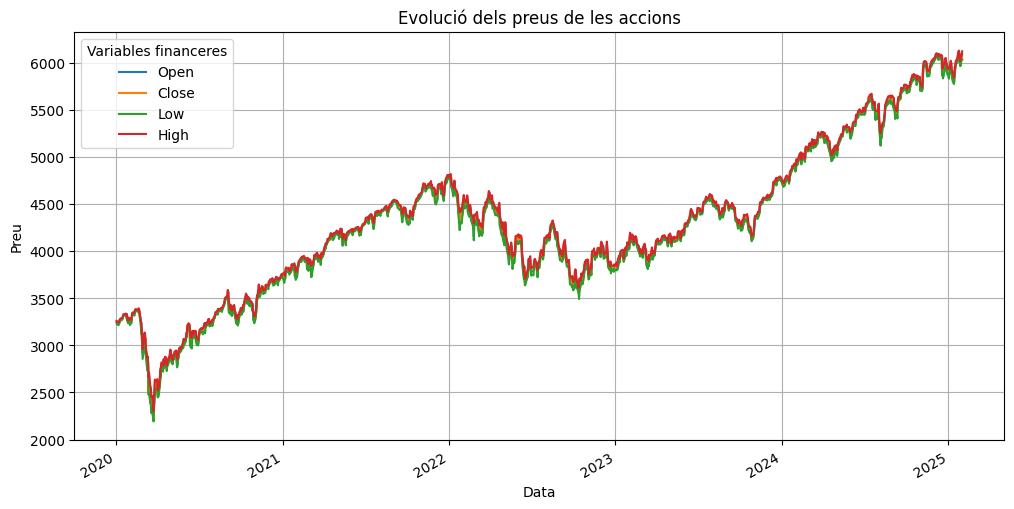

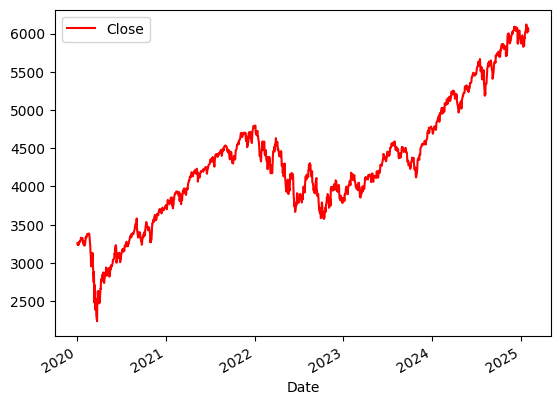

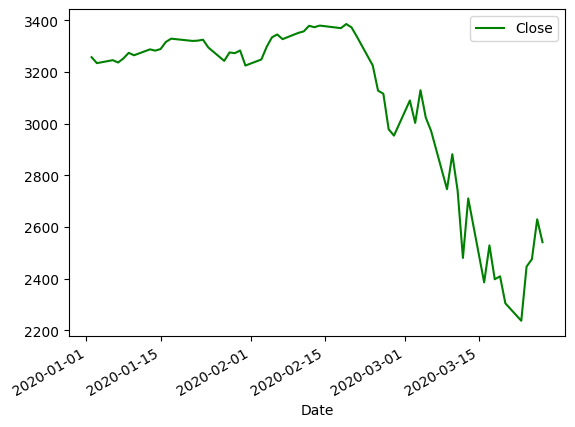

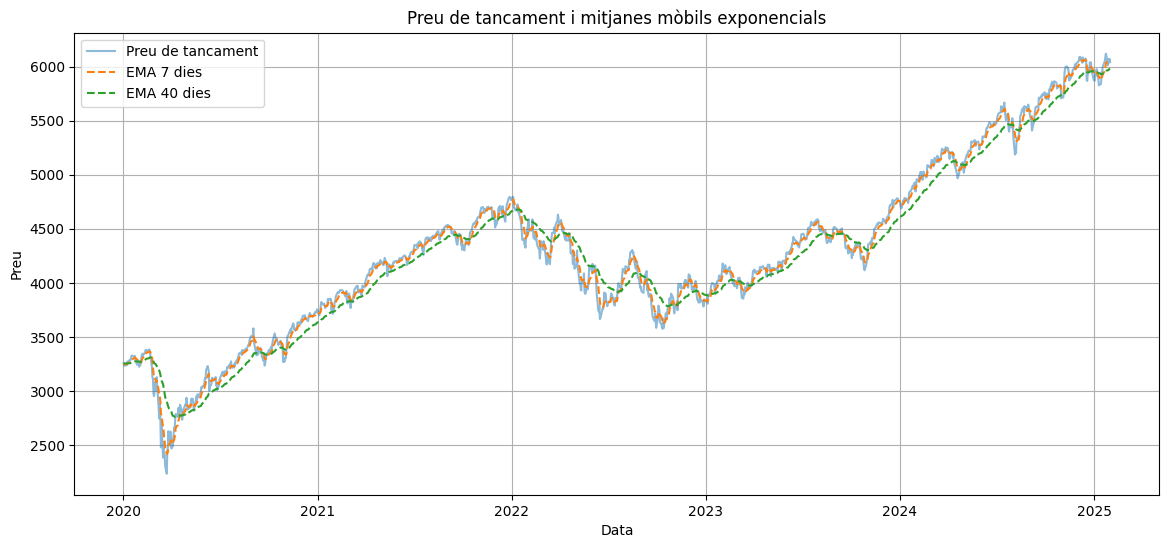

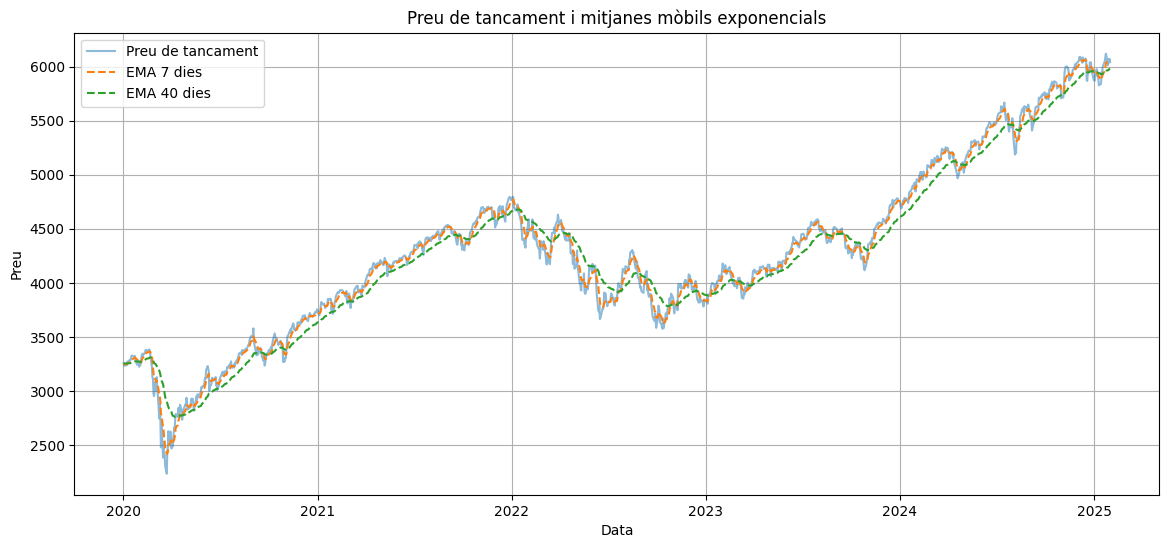

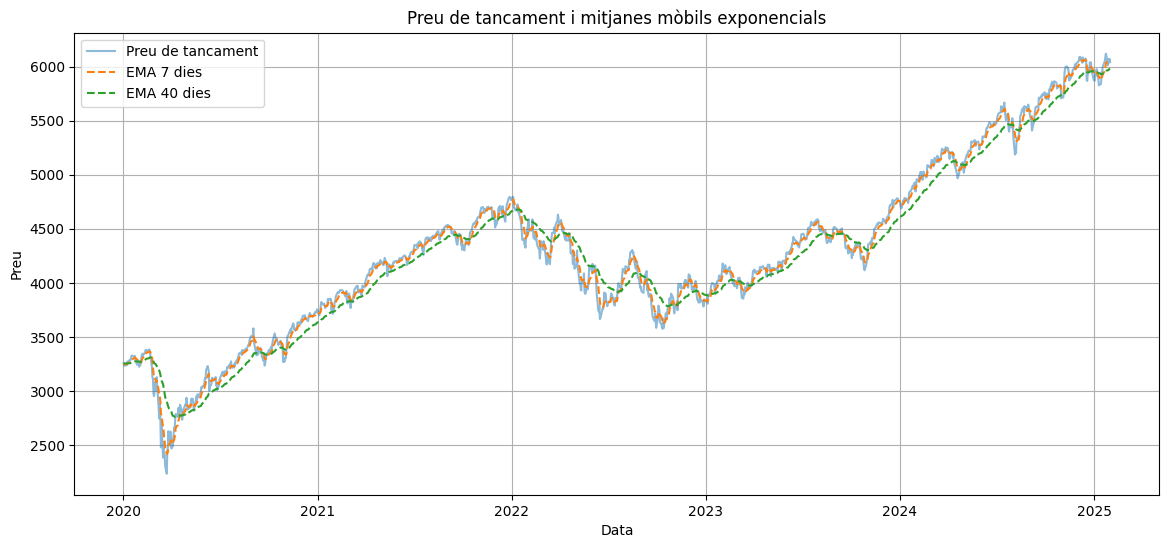

In [23]:
%matplotlib inline

df['EMA_7'] = exponential_moving_average(df['Close'], 7)
df['EMA_40'] = exponential_moving_average(df['Close'], 40)
graphic_exponential_moving_average(df)

In [ ]:
# Funció per calcular el MACD, la línia de senyal i l'histograma
def calculate_macd(df, short_period=12, long_period=26, signal_period=9):
    
    # Calcular la mitjana mòbil exponencial curta i llarga del preu de tancament
    ema_short = exponential_moving_average(df['Close'], short_period)
    ema_long = exponential_moving_average(df['Close'], long_period)

    # Calcular el MACD com la diferència entre les dues EMAs
    macd = ema_short - ema_long

    # Calcular la línia de senyal (mitjana suau del MACD)
    signal_line = exponential_moving_average(macd, signal_period)

    # Calcular l'histograma com la diferència entre el MACD i la línia de senyal
    macd_hist = macd - signal_line

    # Afegir les columnes resultants al DataFrame
    df['MACD'] = macd
    df['Signal_Line'] = signal_line
    df['MACD_Hist'] = macd_hist

    return df

# Funció per visualitzar el MACD, la línia de senyal i l'histograma
def calculate_macd_graph(df):
    # Verifiquem si la columna "Date" existeix per utilitzar-la a l'eix X
    if 'Date' in df.columns:
        x = df['Date']
    else:
        x = df.index  # Si no, usem l'índex (suposadament dates també)

    # Crear una nova figura per plotejar
    plt.figure(figsize=(14,6))

    # Dibuixar la línia del MACD
    plt.plot(x, df['MACD'], label='MACD', color='blue')

    # Dibuixar la línia de senyal
    plt.plot(x, df['Signal_Line'], label='Línia de senyal', color='orange')

    # Dibuixar l'histograma (com barres)
    plt.bar(x, df['MACD_Hist'], label='Histograma', color='gray', alpha=0.3)

    plt.title('MACD')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    plt.show()


In [ ]:

df = calculate_macd(df)
calculate_macd_graph(df)


C:\Users\jesus\AppData\Local\Temp\ipykernel_10508\4210167277.py:49: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [ ]:
import numpy as np
import pandas as pd

# Calcula l'RSI utilitzant l'exponential weighted moving average (EWM) i afegeix una columna "RSI" al DataFrame.
def calculate_rsi_ewm(df, period=14):
    
    delta = df['Close'].diff()  # Calcular la variació diària del preu de tancament

    # Calcular els guanys i les pèrdues: els guanys són les variacions positives, les pèrdues són les negatives (en valor absolut)
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    # Calcular la mitjana exponencial dels guanys i les pèrdues.
    avg_gain = gain.ewm(alpha=1/period, adjust=False, min_periods=period).mean()
    avg_loss = loss.ewm(alpha=1/period, adjust=False, min_periods=period).mean()

    # Calcular la força relativa (RS)
    rs = avg_gain / avg_loss

    # Calcular l'RSI
    rsi = 100 - (100 / (1 + rs))

    df['RSI'] = rsi
    
    return df

df = calculate_rsi_ewm(df, period=14)


In [ ]:
import pandas as pd
import numpy as np

#Calcula l'ATR (Average True Range) utilitzant el càlcul recursiu de Wilder.
def calculate_atr_recursive(df, period=14):
 
    # Calcular el True Range (TR)
    high_low = df['High'] - df['Low']
    high_prev_close = abs(df['High'] - df['Close'].shift(1))
    low_prev_close = abs(df['Low'] - df['Close'].shift(1))
    tr = pd.concat([high_low, high_prev_close, low_prev_close], axis=1).max(axis=1)
    
    atr_values = []  # Llista on anirem emmagatzemant els valors d'ATR
    
    # Per a les primeres 'period' files no es pot calcular ATR de manera recursiva
    for i in range(len(tr)):
        if i < period:
            atr_values.append(np.nan)  # Assignem NaN fins que tinguem suficients dades
        elif i == period:
            # Primer valor d'ATR: mitjana simple dels TR dels primers 'period' dies
            initial_atr = tr.iloc[i - period + 1:i + 1].mean()
            atr_values.append(initial_atr)
        else:
            # Calcular l'ATR recursiu
            atr_today = ((atr_values[i - 1] * (period - 1)) + tr.iloc[i]) / period
            atr_values.append(atr_today)
    
    df['ATR'] = atr_values
    return df


df = calculate_atr_recursive(df, period=14)


In [ ]:
#Imputar els valors NaN amb el primer valor vàlid.
df['RSI'] = df['RSI'].fillna(method='bfill')  
df['ATR'] = df['ATR'].fillna(method='bfill')

C:\Users\jesus\AppData\Local\Temp\ipykernel_10508\1042102371.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['RSI'] = df['RSI'].fillna(method='bfill')
C:\Users\jesus\AppData\Local\Temp\ipykernel_10508\1042102371.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['ATR'] = df['ATR'].fillna(method='bfill')


Guardar el dataset amb tots els canvis.

In [ ]:
df.to_csv("Conjunt de dades Preprocessades/S&P500_Stock_Price_output.csv", index=False)

Canvi gràfiques 

In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd

def graph(df, name, out_dir):
    # Indexar per data sense perdre la columna
    df_indexed = df.set_index('Date', drop=False)

    # Gràfic Open, Close, Low, High
    plt.figure(figsize=(12, 6))
    df_indexed[['Open', 'Close', 'Low', 'High']].plot(grid=True, ax=plt.gca())
    plt.title(f'Evolució dels preus de les accions – {name}')
    plt.xlabel('Data')
    plt.ylabel('Preu')
    plt.legend(title="Variables financeres")
    plt.savefig(os.path.join(out_dir, f'{name}_preus_històrics.png'))
    plt.close()

    

# Directori on estan els datasets
base_dir = 'Conjunt de dades Preprocessades/Datasets'

# Directori de sortida per a les imatges
out_dir = 'Conjunt de dades Preprocessades/Gràfiques Preus Històrics'
os.makedirs(out_dir, exist_ok=True)

# Llista de noms de fitxer
filenames = [
    'Amazon_Stock_Price_output.csv',
    'Euro_Stoxx_50_Stock_Price_output.csv',
    'Google_Stock_Price_output.csv',
    'Hang_Seng_Stock_Price_output.csv',
    'IBEX_35_Stock_Price_output.csv',
    'Indra_Stock_Price_output.csv',
    'P&G_Stock_Price_output.csv',
    'S&P500_Stock_Price_output.csv',
]

for fname in filenames:
    # Construir camí complet
    path = os.path.join(base_dir, fname)
    # Nom “amable” sense _output.csv
    name = os.path.splitext(fname)[0].replace('_output', '')
    # Llegir CSV (parsejar dates)
    df = pd.read_csv(path, parse_dates=['Date'])
    # Crear gràfics
    graph(df, name, out_dir)
